## Multilayer perceptron (MLP) overview

The Multilayer Perceptron (MLP) is a type of feedforward neural network used to approach [multiclass classification](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/video-lecture) problems. Before building an MLP, it is crucial to understand the concepts of perceptrons, layers, and activation functions.

Multilayer Perceptrons are made up of functional units called perceptrons. The equation of a  perceptron is as follows:

$$Z = \vec{w}⋅\mathrm{X} + b$$

where

* $Z$: perceptron output
* $\mathrm{X}$: feature matrix
* $\vec{w}$: weight vector
* $b$: bias

When these perceptrons are stacked, they form structures called dense layers which can then be connected to build a neural network. A dense layer's equation is similar to that of a perceptron's but uses a weight matrix and a bias vector instead:

$$Z = \mathrm{W}⋅\mathrm{X} + \vec{b}$$

where

* $Z$: dense layer output
* $\mathrm{X}$: feature matrix
* $\mathrm{W}$: weight matrix
* $\vec{b}$: bias vector


In an MLP, multiple dense layers are connected in such a way that the outputs of one layer are fully connected to the inputs of the next layer. Adding non-linear activation functions to the outputs of dense layers can help the MLP classifier learn complex decision boundaries and generalize well to unseen data.

In [ ]:
# Use seaborn for countplot.
!pip install -q seaborn

In [ ]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
# Set random seed for reproducible results
tf.random.set_seed(22)

2.14.0


In [ ]:
train_data, val_data, test_data = tfds.load("mnist",
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


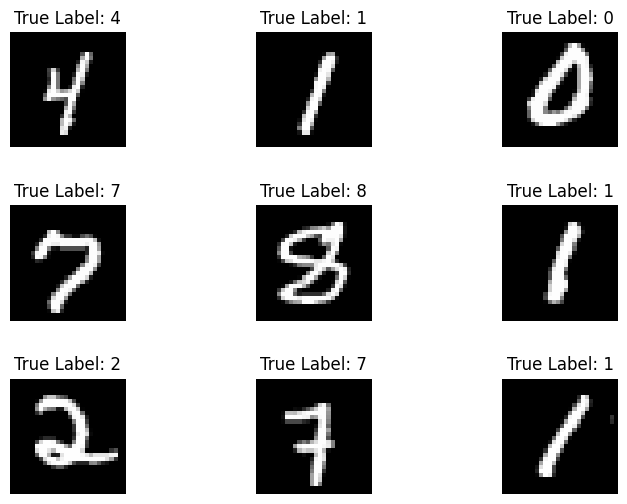

In [ ]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
x_viz = tf.squeeze(x_viz, axis=3)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)


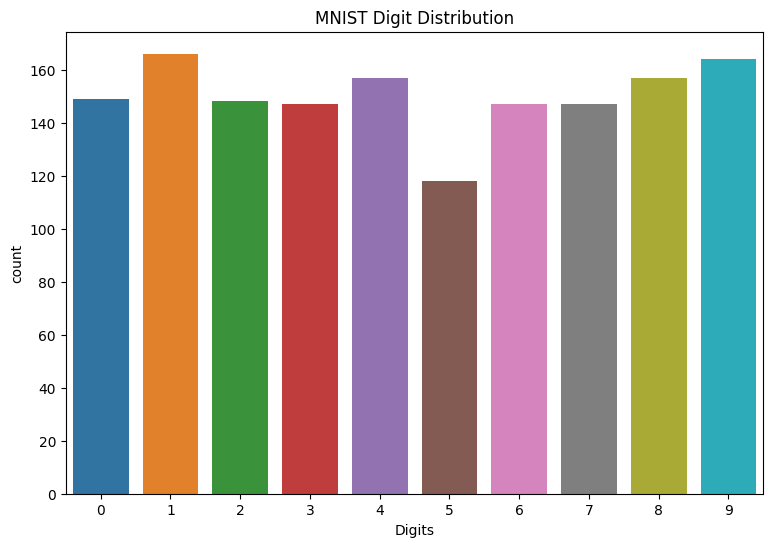

In [ ]:
sns.countplot(x=y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

In [ ]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

## Build the MLP

Start by visualizing the [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) and [Softmax](https://developers.google.com/machine-learning/glossary#softmax) activation functions. Both functions are available in `tf.nn.relu` and `tf.nn.softmax` respectively. The ReLU is a non-linear activation function that outputs the input if it is positive and 0 otherwise:

$$\text{ReLU}(X) = max(0, X)$$

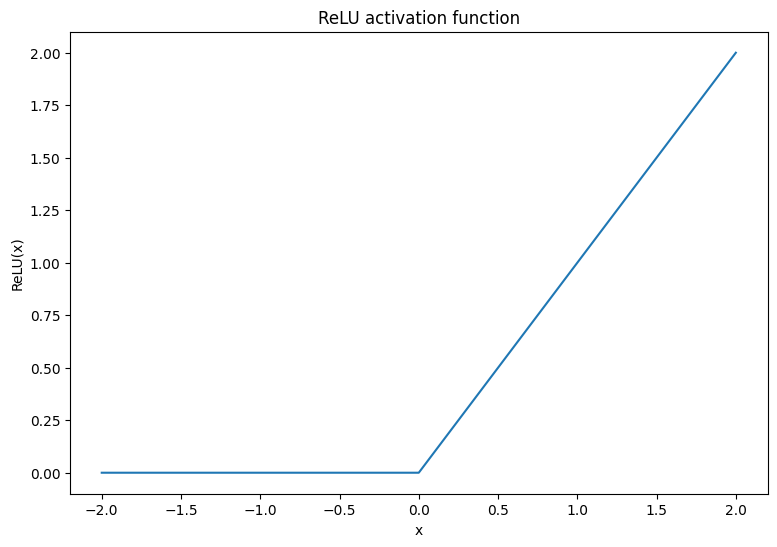

In [ ]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.relu(x));
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU activation function');

The softmax activation function is a normalized exponential function that converts $m$ real numbers into a probability distribution with $m$ outcomes/classes. This is useful for predicting class probabilities from a neural network's output:

$$\text{Softmax}(X) = \frac{e^{X}}{\sum_{i=1}^{m}e^{X_i}}$$

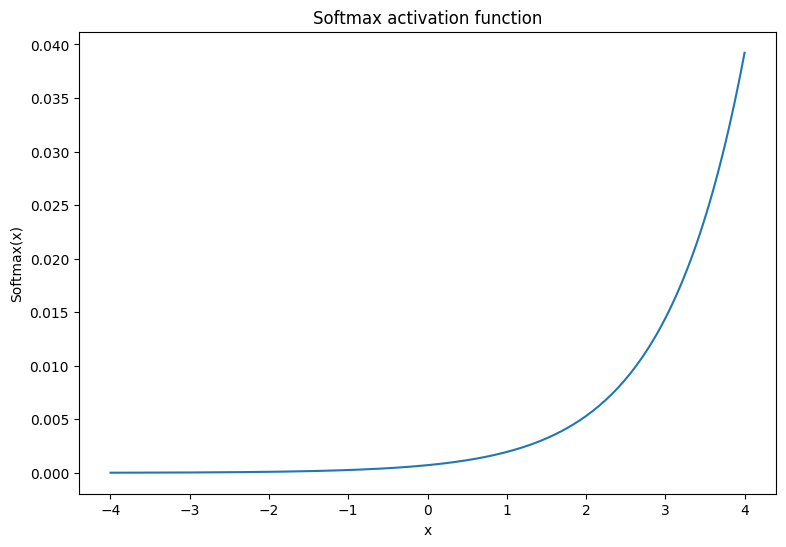

In [ ]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0));
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Softmax activation function');

In [ ]:
def xavier_init(shape):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim),
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22)
  return weight_vals

In [ ]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]
      # Initialize the weights and biases
      self.w = tf.Variable(self.weight_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

In [ ]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers

  @tf.function
  def __call__(self, x, preds=False):
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

In [ ]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

In [ ]:
def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [ ]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False

    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return

In [ ]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [ ]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.222, Training accuracy: 0.934
Validation loss: 0.121, Validation accuracy: 0.963
Epoch: 1
Training loss: 0.079, Training accuracy: 0.975
Validation loss: 0.099, Validation accuracy: 0.971
Epoch: 2
Training loss: 0.047, Training accuracy: 0.986
Validation loss: 0.088, Validation accuracy: 0.976
Epoch: 3
Training loss: 0.034, Training accuracy: 0.989
Validation loss: 0.095, Validation accuracy: 0.975
Epoch: 4
Training loss: 0.026, Training accuracy: 0.992
Validation loss: 0.110, Validation accuracy: 0.971
Epoch: 5
Training loss: 0.023, Training accuracy: 0.992
Validation loss: 0.103, Validation accuracy: 0.976
Epoch: 6
Training loss: 0.018, Training accuracy: 0.994
Validation loss: 0.096, Validation accuracy: 0.979
Epoch: 7
Training loss: 0.017, Training accuracy: 0.994
Validation loss: 0.110, Validation accuracy: 0.977
Epoch: 8
Training loss: 0.017, Training accuracy: 0.994
Validation loss: 0.117, Validation accuracy: 0.976
Epoch: 9
Training loss: 0.013, Traini

### Performance evaluation

Start by writing a plotting function to visualize the model's loss and accuracy during training.

In [ ]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");

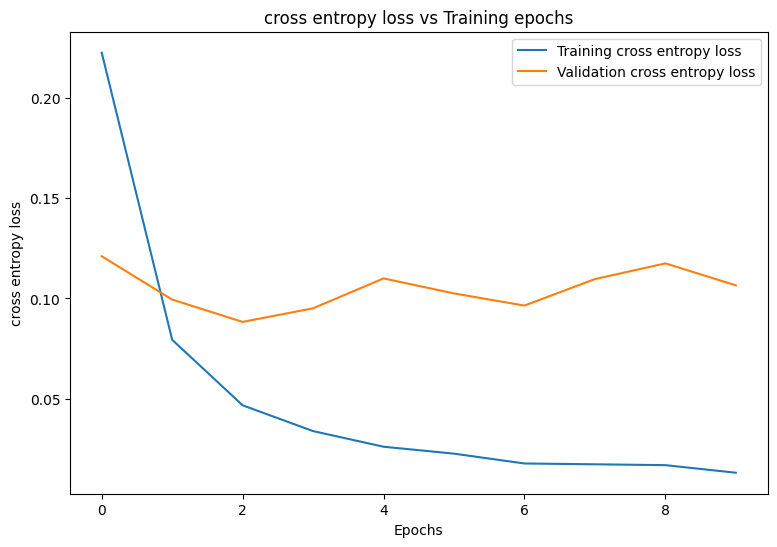

In [ ]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

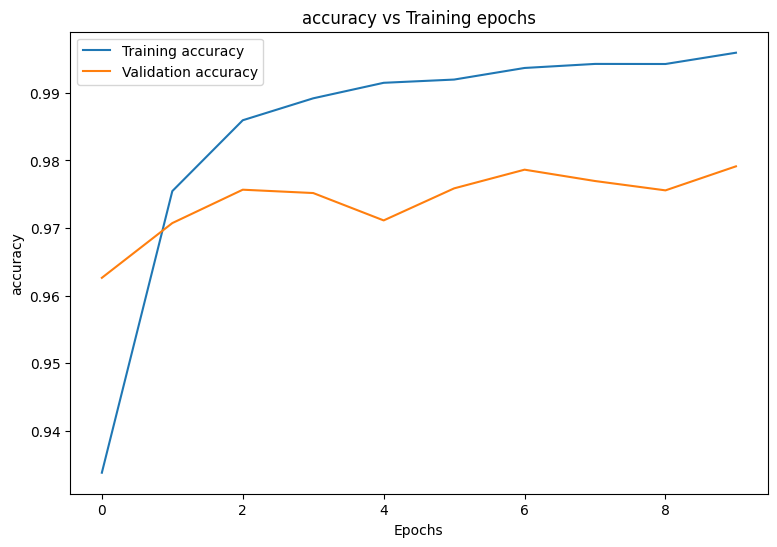

In [ ]:
plot_metrics(train_accs, val_accs, "accuracy")

In [ ]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)])
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    y = self.class_pred(y)
    return y

In [ ]:
def preprocess_test(x):
  # The export module takes in unprocessed and unlabeled data
  x = tf.reshape(x, shape=[-1, 784])
  x = x/255
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)

In [ ]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [ ]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

In [ ]:
mlp_loaded = tf.saved_model.load(save_path)

In [ ]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.979


In [ ]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 6: 0.969
Digit 9: 0.972
Digit 7: 0.973
Digit 5: 0.974
Digit 3: 0.977
Digit 4: 0.979
Digit 0: 0.981
Digit 8: 0.982
Digit 2: 0.987
Digit 1: 0.992


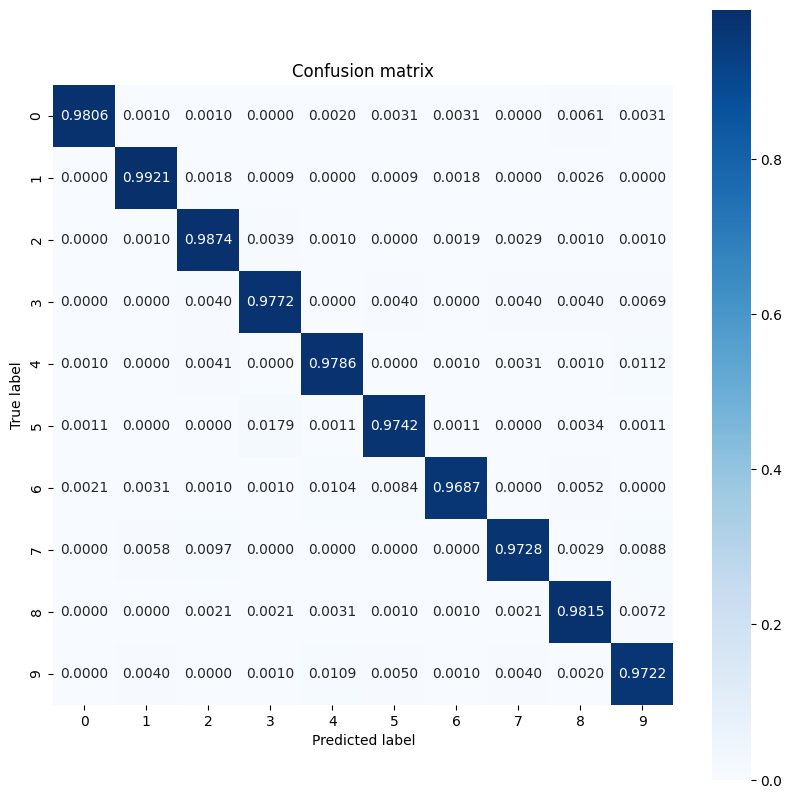

In [ ]:
import sklearn.metrics as sk_metrics

def show_confusion_matrix(test_labels, test_classes):
  # Compute confusion matrix and normalize
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels.numpy(),
                                          test_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(10)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(y_test, test_classes)